# Main analysis file

We load up one large dataframe consisting of all simulation sweeps and curves, produced by [src/get_all_data.py](../get_all_data.py).

In [63]:
import hydra

import numpy as np
import pandas as pd
import plotnine as pn

from hydra.core.global_hydra import GlobalHydra

# Lets us import ibsg modules
import sys
sys.path.append("/Users/nathanielimel/uci/projects/ibsg/src")

from game.game import Game

## Load main dataframe

In [64]:
all_data_fp = "../../analysis_data/all_data.csv"

In [65]:
df = pd.read_csv(all_data_fp)
df

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,universe,prior,num_signals,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed
0,1.359284,1.164133,0.747895,2.637992e+00,[0.005615214794894907],0.009838,0.993093,0.0,simulation,NaN,...,10,-8,10,squared_dist,0.0,0,replicator_diffusion,0.0,2.0,42.0
1,2.519327,1.228943,0.683085,1.664377e+01,NaN,NaN,NaN,1.0,trajectory,0.0,...,10,-8,10,squared_dist,0.0,0,replicator_diffusion,0.0,2.0,42.0
2,1.480953,1.146769,0.765259,1.051718e+01,NaN,NaN,NaN,1.0,trajectory,1.0,...,10,-8,10,squared_dist,0.0,0,replicator_diffusion,0.0,2.0,42.0
3,1.272988,1.046270,0.865758,3.325289e+00,NaN,NaN,NaN,1.0,trajectory,2.0,...,10,-8,10,squared_dist,0.0,0,replicator_diffusion,0.0,2.0,42.0
4,1.255186,1.073075,0.838953,2.971476e+00,NaN,NaN,NaN,1.0,trajectory,3.0,...,10,-8,10,squared_dist,0.0,0,replicator_diffusion,0.0,2.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31319,6.643856,NaN,NaN,4.877432e-14,NaN,NaN,NaN,NaN,mse_bound,NaN,...,100,-8,100,squared_dist,NaN,0,NaN,NaN,NaN,NaN
31320,6.643856,NaN,NaN,3.804261e-14,NaN,NaN,NaN,NaN,mse_bound,NaN,...,100,-8,100,squared_dist,NaN,0,NaN,NaN,NaN,NaN
31321,6.643856,NaN,NaN,2.967218e-14,NaN,NaN,NaN,NaN,mse_bound,NaN,...,100,-8,100,squared_dist,NaN,0,NaN,NaN,NaN,NaN
31322,6.643856,NaN,NaN,2.314348e-14,NaN,NaN,NaN,NaN,mse_bound,NaN,...,100,-8,100,squared_dist,NaN,0,NaN,NaN,NaN,NaN


## Set parameters for one theoretical bound

Using hydra compose overrides.

In [66]:
overrides = [
    # "game.universe=c1",

    # "game.universe=100",
    # "game.num_signals=100",

    # "simulation/dynamics=imprecise_conditional_imitation"

    # "game.universe=2ball_300",
    # "game.num_signals=300",

] # n.b.: do not include multirun overrides, we will filter from columns in the dataframe.

# Global initialization
GlobalHydra.instance().clear() # from previous runs of notebook
hydra.initialize(version_base=None, config_path="../../conf")
config = hydra.compose(
    config_name="config",
    overrides=overrides,
)


#### Meaning distributions

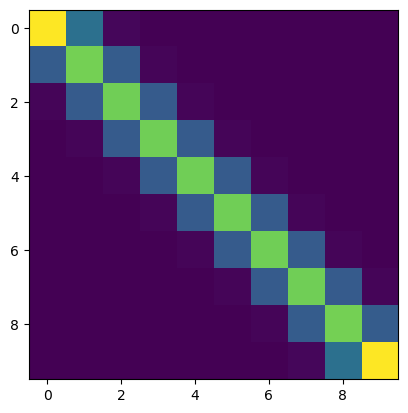

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt

game = Game.from_hydra(config, cwd="/Users/nathanielimel/uci/projects/ibsg/data")
plt.imshow(game.meaning_dists)

#### helper function for subsetting

In [68]:
def get_df_subsetted_by_bound(df: pd.DataFrame, config) -> pd.DataFrame:
    """Return a subset of the data consistent with the specifications in the config."""

    # Configs specific only to the game (not dynamics)
    curve_metadata = config.game

    # See src/get_all_data.py
    universe = df["universe"].astype(str) == str(curve_metadata.universe)
    prior = df["prior"].astype(str) == str(curve_metadata.prior)
    num_signals = df["num_signals"] == curve_metadata.num_signals # this is prob not necessary
    distance = df["distance"] == curve_metadata.distance

    meaning_dist_gamma = df["meaning_dist_gamma"] == curve_metadata.meaning_dist_gamma

    dynamics = df["dynamics"].isin([
        config.simulation.dynamics.name, # target dynamics
        np.nan, # for NaNs to allow the ib curve itself
    ])

    df_subsetted = df[universe & prior & num_signals & num_signals & distance & meaning_dist_gamma & dynamics]

    return df_subsetted

### Subset dataframes for plotting

In [69]:
# visualize the curve!
df = get_df_subsetted_by_bound(df, config)
df

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,universe,prior,num_signals,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed
0,1.359284,1.164133,0.747895,2.637992e+00,[0.005615214794894907],0.009838,0.993093,0.0,simulation,NaN,...,10,-8,10,squared_dist,0.0,0,replicator_diffusion,0.0,2.0,42.0
1,2.519327,1.228943,0.683085,1.664377e+01,NaN,NaN,NaN,1.0,trajectory,0.0,...,10,-8,10,squared_dist,0.0,0,replicator_diffusion,0.0,2.0,42.0
2,1.480953,1.146769,0.765259,1.051718e+01,NaN,NaN,NaN,1.0,trajectory,1.0,...,10,-8,10,squared_dist,0.0,0,replicator_diffusion,0.0,2.0,42.0
3,1.272988,1.046270,0.865758,3.325289e+00,NaN,NaN,NaN,1.0,trajectory,2.0,...,10,-8,10,squared_dist,0.0,0,replicator_diffusion,0.0,2.0,42.0
4,1.255186,1.073075,0.838953,2.971476e+00,NaN,NaN,NaN,1.0,trajectory,3.0,...,10,-8,10,squared_dist,0.0,0,replicator_diffusion,0.0,2.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27416,3.321928,NaN,NaN,4.737079e-15,NaN,NaN,NaN,NaN,mse_bound,NaN,...,10,-8,10,squared_dist,NaN,0,NaN,NaN,NaN,NaN
27417,3.321928,NaN,NaN,3.694790e-15,NaN,NaN,NaN,NaN,mse_bound,NaN,...,10,-8,10,squared_dist,NaN,0,NaN,NaN,NaN,NaN
27418,3.321928,NaN,NaN,2.881834e-15,NaN,NaN,NaN,NaN,mse_bound,NaN,...,10,-8,10,squared_dist,NaN,0,NaN,NaN,NaN,NaN
27419,3.321928,NaN,NaN,2.247750e-15,NaN,NaN,NaN,NaN,mse_bound,NaN,...,10,-8,10,squared_dist,NaN,0,NaN,NaN,NaN,NaN


In [70]:
df_final_points = df[df["point_type"] == "simulation"]
df_curve_points = df[df["point_type"] == "ib_bound"]

In [71]:
df_final_points

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,universe,prior,num_signals,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed
0,1.359284e+00,1.164133e+00,0.747895,2.637992,[0.005615214794894907],9.838446e-03,0.993093,0.0,simulation,NaN,...,10,-8,10,squared_dist,0.0,0,replicator_diffusion,0.0,2.0,42.0
202,1.353270e+00,1.160334e+00,0.751694,2.649214,[0.003544876288966048],7.607561e-03,0.993093,0.0,simulation,NaN,...,10,-8,10,squared_dist,0.0,0,replicator_diffusion,0.0,3.0,42.0
404,1.359553e+00,1.164303e+00,0.747724,2.637505,[0.0057115017161304404],9.937061e-03,0.993093,0.0,simulation,NaN,...,10,-8,10,squared_dist,0.0,0,replicator_diffusion,0.0,-1.0,42.0
606,1.360147e+00,1.164687e+00,0.747341,2.636224,[0.0059486600526150735],1.014975e-02,0.993093,0.0,simulation,NaN,...,10,-8,10,squared_dist,0.0,0,replicator_diffusion,0.0,-8.0,42.0
808,1.358994e+00,1.163955e+00,0.748072,2.638420,[0.005523489556870764],9.724994e-03,0.993093,0.0,simulation,NaN,...,10,-8,10,squared_dist,0.0,0,replicator_diffusion,0.0,1.0,42.0
1010,1.359069e+00,1.163993e+00,0.748035,2.638491,[0.0055276295329361735],9.762329e-03,0.993093,0.0,simulation,NaN,...,10,-8,10,squared_dist,0.0,0,replicator_diffusion,0.0,0.0,42.0
1212,1.358271e+00,1.163493e+00,0.748535,2.639938,[0.005250466567426115],9.462813e-03,0.993093,0.0,simulation,NaN,...,10,-8,10,squared_dist,0.0,0,replicator_diffusion,0.0,-3.0,42.0
1414,1.360038e+00,1.164615e+00,0.747412,2.636476,[0.005903479401069833],1.011151e-02,0.993093,0.0,simulation,NaN,...,10,-8,10,squared_dist,0.0,0,replicator_diffusion,0.0,-2.0,42.0
1616,1.496888e+00,1.252143e+00,0.659884,2.336379,[0.00619439866828797],1.246994e-02,1.076877,0.0,simulation,NaN,...,10,-8,10,squared_dist,1.0,0,replicator_diffusion,0.0,2.0,42.0
1818,1.451046e+00,1.223940e+00,0.688088,2.419335,[0.0079341242237706],1.014235e-02,1.048949,0.0,simulation,NaN,...,10,-8,10,squared_dist,1.0,0,replicator_diffusion,0.0,3.0,42.0


### Plot

In [74]:
# convert seed to categorical
df_final_points.seed = df_final_points.seed.astype(str)

#### Trade-offs

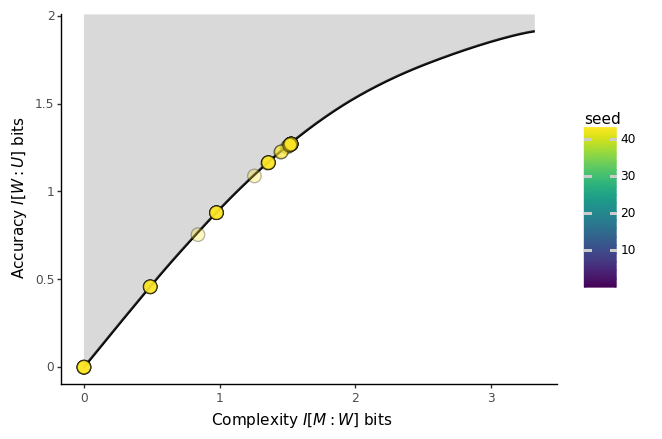

In [73]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_curve_points, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=1) # IB curve
    # + pn.geom_point(size=1)
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=np.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # emergent langs
        data=df_final_points,
        mapping=pn.aes(
            fill="seed",
            # fill="discriminative_need_gamma",
            # fill="imprecise_imitation_gamma",
            # fill="population_init_gamma",
            ),
        alpha=0.3,
        size=5,
    )        
    + pn.xlab("Complexity $I[M:W]$ bits")
    + pn.ylab("Accuracy $I[W:U]$ bits")
    + pn.theme_classic()
)
print(plot)

In [ ]:
# some scratch 
def plot_pressure_limits(
        pressure: str, 
        # pressure_min: float,
        # pressure_max: float,
        ) -> pn.ggplot:
    emergent_data = df_final_points[df_final_points["imprecise_imitation_gamma"] == -3]
    return (
        # Set data and the axes
        pn.ggplot(
            data=df_curve_points, mapping=pn.aes(x="complexity", y="accuracy")
        )  
        + pn.geom_line(size=1) # IB curve
        # + pn.geom_point(size=1)
        + pn.geom_ribbon(
        mapping=pn.aes(
            x="complexity",
            ymin="accuracy",
            ymax=np.inf,
            ),
            fill="gray",
            alpha=0.3,
        )
        + pn.geom_point( # emergent langs
            data=emergent_data,
            mapping=pn.aes(
                fill = pressure,
                ),
            alpha=0.3,
            size=5,
        )        
        + pn.xlab("Complexity $I[M:W]$ bits")
        + pn.ylab("Accuracy $I[W:U]$ bits")
        + pn.theme_classic()
    )
plot_pressure_limits(
    pressure="discriminative_need_gamma",
    # pressure_min=0,
    # pressure_max=0,
)

In [ ]:
# df_final_points["noise"] = df_final_points["noise_cond_ent"]
df_final_points["imprecise_imitation_gamma"] = 10 ** df_final_points["imprecise_imitation_gamma"]

plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_curve_points, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=3) # IB curve
    # + pn.geom_point(size=1)
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=np.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # emergent langs
        data=df_final_points,
        mapping=pn.aes(
            # fill="population_init_gamma",
            # fill="discriminative_need_gamma",
            # fill="noise",
            fill="imprecise_imitation_gamma",
            # shape="language",
            ),
        alpha=0.3,
        size=5,
    )
    # + pn.labs(fill="noise, $H(X|Y)$ bits")
    # + pn.labs(fill="discriminative need")
    # + pn.labs(fill="initialization energy")
    # + pn.labs(fill="perceptual certainty")
    + pn.labs(fill="$\\alpha$ (perceptual certainty)")
    + pn.scale_fill_continuous(
        trans = "log10",
    #     # breaks=[0., 0.5, 1.],
    #     breaks=[0., 1.,],
    #     # labels=["low", "mid", "high"],
    #     labels=["low", "high"],
    )
    + pn.xlab("Complexity, $I(M;W)$ bits")
    + pn.ylab("Accuracy, $I(W;U)$ bits")

    # force axes to origin. Note this blocks the perfectly simple point!
    # + pn.scale_x_continuous(expand = (0, 0)) 
    # + pn.scale_y_continuous(expand = (0, 0))

    + pn.theme_classic()
    + pn.theme(
        # Axis font
        axis_title=pn.element_text(size=24),
        axis_text=pn.element_text(size=12),
        # Legend position
        legend_position=(0.75, 0.31),
        # legend_position='none',
        legend_direction = "vertical",
        # Legend box
        legend_background=pn.element_rect(
            fill="lightgrey",
            size=0.5, linetype="solid", 
            color="darkblue",
        ),
    )
    # guide not working, maybe should just use R
    + pn.guides(
        # fill = pn.guide_legend(
        fill = pn.guide_colorbar(
            title_position = "bottom", 
            # hjust = 0.5 centers the title horizontally
            # title_hjust = 0.8,
            # title_vjust = 2.,
            label_position = "bottom",
            override_aes = {"alpha":0.8},
            # nrow=3,
            ),
    ) 
)
print(plot)
plot.save("main_figure", width=6, height=6, dpi=300,)

In [ ]:
df_traj_points = df[df["point_type"] == "trajectory"]
df_traj_points["iteration"] = df_traj_points["round"]
df_traj_points

In [ ]:
# df_traj_points[df_traj_points["imprecise_imitation_gamma"] == 0.]

new_df = df_traj_points.loc[(df_traj_points['imprecise_imitation_gamma'] == 0) & (df_traj_points['population_init_gamma'] == -2) & (df_traj_points["discriminative_need_gamma"] == -2)]

# new_df = df_traj_points.loc[(df_traj_points['imprecise_imitation_gamma'] == 3) & (df_traj_points["discriminative_need_gamma"] == -2)]

# new_df = df_traj_points.loc[(df_traj_points['population_init_gamma'] == -2) & (df_traj_points["discriminative_need_gamma"] == -2)]

new_df

In [ ]:
threshold = -1
df_sample_traj = df_traj_points[df_traj_points["imprecise_imitation_gamma"] == threshold]
df_sample_points = df_final_points[df_final_points["imprecise_imitation_gamma"] == threshold]
# df_sample_traj = df_sample_traj[df_sample_traj["discriminative_need_gamma"] == 0]

# just want like three representative trajectories.


plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_curve_points, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    # + pn.geom_point(size=1)
    + pn.geom_line(size=1) # IB curve    
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=np.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # trajectories
    # + pn.geom_line(
        data=new_df,
        mapping=pn.aes(
            fill="iteration",
            # color="imprecise_imitation_gamma"
            # color="population_init_gamma",
            ),
        alpha=0.3,
        size=5,
    )
    # + pn.geom_point( # emergent langs
    #     data=df_sample_points,
    #     mapping=pn.aes(
    #         color="population_init_gamma",
    #         ),
    #     # alpha=0.05,
    #     shape="X",
    #     size=3,
    # )    
    + pn.labs(fill="iteration")
    + pn.scale_fill_continuous(
        breaks=[0, 50, 100, 150, 200],
        limits=[0, 200],
    )
    + pn.xlab("Complexity, $I(M;W)$ bits")
    + pn.ylab("Accuracy, $I(W;U)$ bits")

    # force axes to origin. Note this blocks the perfectly simple point!
    # + pn.scale_x_continuous(expand = (0, 0)) 
    # + pn.scale_y_continuous(expand = (0, 0))

    + pn.theme_classic()
    + pn.theme(
        # Axis font
        axis_title=pn.element_text(size=24),
        axis_text=pn.element_text(size=12),
        # Legend position
        legend_position=(0.75, 0.325),
        # legend_position='none',
        legend_direction = "vertical",
        # Legend box
        legend_background=pn.element_rect(
            fill="lightgrey",
            size=0.5, linetype="solid", 
            color="darkblue",
        ),
    )
    # guide not working, maybe should just use R
    + pn.guides(
        # fill = pn.guide_legend(
        fill = pn.guide_colorbar(
            title_position = "bottom", 
            # hjust = 0.5 centers the title horizontally
            title_hjust = 0.8,
            title_vjust = 2.,
            label_position = "bottom",
            override_aes = {"alpha":0.8},
            # nrow=3,
            ),
    ) 
)
print(plot)
plot.save("traj_figure", width=6, height=6, dpi=300,)

### 3D plot of parameterspace

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

f = lambda x, y: np.sin(x) * np.cos(y)
# x = np.linspace(-3, 3, 100)
# y = np.linspace(-3, 3, 100)
x = np.arange(-3, 4)
y = np.arange(-3, 4)
X, Y = np.meshgrid(x, y)
F = f(X, Y)

fig = plt.figure(figsize=[12,8])
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, F, cmap='magma')
plt.show()

In [ ]:
print(X.shape)
print(Y.shape)
print(F.shape)

In [ ]:
def lookup_efficiency(discr_need: int, imprecision: int) -> float:
    df_discr = df_final_points[df_final_points["discriminative_need_gamma"] == discr_need]
    df_imprecision = df_discr[df_discr["imprecise_imitation_gamma"] == imprecision]
    # need to fix population init
    df_result = df_imprecision[df_imprecision["population_init_gamma"] == 0.]
    eps = float(df_result["eps"].tolist()[0]) # return singleton
    return eps

x = np.arange(-3, 4) # discr_need
y = np.arange(-3, 4) # imprecise imitation

X, Y = np.meshgrid(x, y)

# we need to create the equivalent of matrix elementwise multiplication / conjunction.
# if before we had sin(x) * cos(y),
# this was really
# sin(x_ij) * cos(y_ij) for i in ... for j in ...
# 
# then before our df[...] == x & df[...] == y
# should be df[...] == x_ij & df[...] == y_ij for i in ... for j in ...

# square matrix, so we can just use length
n = len(X)
F = np.array([[lookup_efficiency(
    discr_need=X[i,j], 
    imprecision=Y[i,j],
    ) for i in range(n)] for j in range(n)])


def plotter(E, A):
    fig = plt.figure(figsize=[12,8])
    ax = fig.gca(projection='3d')
    ax.plot_surface(
        X=X, Y=Y, Z=F, 
        cmap="viridis",
    )
    ax.view_init(elev=E, azim=A)
    ax.set_xlabel('Discriminative need')
    ax.set_ylabel('Imprecise imitation')
    ax.set_zlabel('Efficiency loss')
    plt.show()

plotter(20, 70)

In [ ]:
# inspect X and Y
X, Y

### Parallel coordinates?

In [ ]:
import plotly.express as px
df = px.data.iris()
fig = px.parallel_coordinates(df, color="species_id", labels={"species_id": "Species",
                "sepal_width": "Sepal Width", "sepal_length": "Sepal Length",
                "petal_width": "Petal Width", "petal_length": "Petal Length", },
                             color_continuous_scale=px.colors.diverging.Tealrose,
                             color_continuous_midpoint=2)
fig.show()

In [ ]:
import plotly.express as px

# df_pcs = df_final_points[["discriminative_need_gamma", "imprecise_imitation_gamma", "population_init_gamma", "eps"]]

# df_final_points["efficiency"] = 1 - df_final_points["eps"] # i don't think F is bounded by one, just need something.

# parallel_data = df_final_points[df_final_points["eps"] >= -np.inf]
parallel_data = df_final_points.copy()
parallel_data["eps"] = parallel_data["eps"] - min(df_final_points["eps"])

fig = px.parallel_coordinates(
    data_frame=parallel_data, 
    dimensions=[
        "population_init_gamma",
        "discriminative_need_gamma",
        "imprecise_imitation_gamma",
        ],
    color="eps",
    # color="efficiency",
    labels={
        "population_init_gamma": "Initialization Energy",
        "discriminative_need_gamma": "Discriminative Need",
        "imprecise_imitation_gamma": "Perceptual Certainty",
        "eps": "Efficiency Loss",
        # "efficiency": "Efficiency",
        },
    # color_continuous_scale='viridis',
    color_continuous_scale=px.colors.diverging.Tealrose,
    # color_continuous_midpoint=0.6,
)
fig.show()
fig.write_image("parcoord.pdf", format="pdf")

In [ ]:
# add dummy columns to see how crowded things get
df_example = df_final_points.copy()

df_example["prior_entropy"] = df_example["discriminative_need_gamma"]
df_example["universe_size"] = df_example["prior_entropy"]

fig = px.parallel_coordinates(
    data_frame=df_example[df_example["eps"] >= 0.], 
    dimensions=[
        "universe_size",
        "prior_entropy",
        "population_init_gamma",        
        "discriminative_need_gamma",
        "imprecise_imitation_gamma",
        ],
    color="eps",
    # color="efficiency",
    labels={
        "population_init_gamma": "Initialization Temperature",        
        "discriminative_need_gamma": "Discriminative Need",
        "imprecise_imitation_gamma": "Perceptual Certainty",
        "prior_entropy": "Communicative Need Entropy",
        "universe_size": "Universe Size",
        "eps": "Efficiency Loss",
        # "efficiency": "Efficiency",
        },
    color_continuous_scale='viridis',
    # color_continuous_scale=px.colors.diverging.Tealrose,
    # color_continuous_midpoint=0.2,
)
fig.show()

In [ ]:
# Easier: histogram of efficiency.
# efficiency loss = eps
# df = df_final_points[df_final_points["eps"] > 0.]
df = df_final_points.copy()
# df = parallel_data.copy()

pressure = "discriminative_need_gamma"
df[pressure] = [ str(item) for item in df[pressure].tolist()]

hist = (
    pn.ggplot(data=df, mapping=pn.aes(x="eps", fill=pressure, color=pressure))
    + pn.geom_density(alpha=0.5)
    + pn.xlim(0, .02)
    + pn.ylim(0,1000)
)
print(hist)
hist.save("epsilon_histogram", width=6, height=6, dpi=300,)

In [ ]:
eps = [ep for ep in df_final_points["eps"].tolist() if not np.isnan(ep)]
print(min(eps))
print(np.median(eps))

### Correlations

In [ ]:
from scipy.stats import linregress, pearsonr

complexity

In [ ]:
print(linregress(
    df_final_points["imprecise_imitation_gamma"],
    df_final_points["complexity"],
))
(
    pn.ggplot(df_final_points, pn.aes(x="imprecise_imitation_gamma", y="complexity"))
    + pn.geom_point(alpha=0.5)
    + pn.geom_smooth(color="orange", method="lm")
)

In [ ]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
X = np.array([ df_final_points["discriminative_need_gamma"].tolist(), 
        df_final_points["imprecise_imitation_gamma"].tolist(), 
        df_final_points["population_init_gamma"].tolist(), 
        ]).T
y = np.array(df_final_points["complexity"].tolist())
reg = reg.fit(X, y)
print(reg.coef_) # indeed the same!
print(reg.score(X, y)) # strictly less info than individual regressions.

In [ ]:
print(linregress(
    df_final_points["discriminative_need_gamma"],
    df_final_points["complexity"],
))
(
    pn.ggplot(df_final_points, pn.aes(x="discriminative_need_gamma", y="complexity"))
    + pn.geom_point(alpha=0.5)
    + pn.geom_smooth(color="orange", method="lm")
)

In [ ]:
print(linregress(
    df_final_points["population_init_gamma"],
    df_final_points["complexity"],
))
(
    pn.ggplot(df_final_points, pn.aes(x="population_init_gamma", y="complexity"))
    + pn.geom_point(alpha=0.5)
    + pn.geom_smooth(color="orange", method="lm")
)

In [ ]:
print(linregress(
    df_final_points["imprecise_imitation_gamma"],
    df_final_points["eps"],
))
(
    pn.ggplot(df_final_points, pn.aes(x="imprecise_imitation_gamma", y="eps"))
    + pn.geom_point(alpha=0.5)
    + pn.geom_smooth(color="orange", method="lm")
)

efficiency

In [ ]:
# df_positive_eps = df_final_points[df_final_points["eps"] > 0.]
# temporary solution: find the max negative eps, and add that to everyone.

min_eps = min(df_final_points["eps"])

df_positive_eps = df_final_points.copy()
df_positive_eps["eps"] = df_positive_eps["eps"] - min_eps # minus neg

In [ ]:
print(linregress(
    df_positive_eps["imprecise_imitation_gamma"],
    df_positive_eps["eps"]
))
(
    pn.ggplot(df_positive_eps, pn.aes(x="imprecise_imitation_gamma", y="eps"))
    + pn.geom_point(alpha=0.5)
    # + pn.geom_smooth(color="orange")
    + pn.geom_col()
)

Cleaned up regressions

In [ ]:
import patchworklib as pw

In [ ]:
noise_comp_reg_p = (
    pn.ggplot(df_final_points, pn.aes(x="imprecise_imitation_gamma", y="complexity"))
    + pn.geom_point(alpha=0.3)
    + pn.geom_smooth(color="orange", method="lm")
    + pn.xlab("Perceptual Certainty, $\\alpha$")
    + pn.ylab("Complexity, $I(M;W)$ bits")
    # + pn.ylab("Efficiency loss, $\epsilon$")
)

discr_comp_reg_p = (
    pn.ggplot(df_final_points, pn.aes(x="discriminative_need_gamma", y="complexity"))
    + pn.geom_point(alpha=0.3)
    + pn.geom_smooth(color="orange", method="lm")
    + pn.xlab("Discriminative Need, $\\gamma$")
    + pn.theme(axis_title_y=pn.element_blank())
)

init_comp_reg_p = (
    pn.ggplot(df_final_points, pn.aes(x="population_init_gamma", y="complexity"))
    + pn.geom_point(alpha=0.3)
    + pn.geom_smooth(color="orange", method="lm")
    + pn.xlab("Initialization Energy, $\\gamma$")
    + pn.theme(axis_title_y=pn.element_blank())
)



In [ ]:
p1 = pw.load_ggplot(noise_comp_reg_p, figsize=(2,2))
p2 = pw.load_ggplot(discr_comp_reg_p, figsize=(2,2))
p3 = pw.load_ggplot(init_comp_reg_p, figsize=(2,2))

g = (p1 | p2 | p3)

g.savefig("comp_reg_multiplot.png")

In [ ]:
noise_eps_reg_p = (
    pn.ggplot(df_positive_eps, pn.aes(x="imprecise_imitation_gamma", y="eps"))
    + pn.geom_point(alpha=0.3)
    + pn.geom_smooth(color="orange", method="lm")
    + pn.xlab("Perceptual Certainty, $\\alpha$")
    + pn.ylab("Efficiency loss, $\epsilon$")
)

discr_eps_reg_p = (
    pn.ggplot(df_positive_eps, pn.aes(x="discriminative_need_gamma", y="eps"))
    + pn.geom_point(alpha=0.3)
    + pn.geom_smooth(color="orange", method="lm")
    + pn.xlab("Discriminative Need, $\\gamma$")
    + pn.theme(axis_title_y=pn.element_blank())
)

init_eps_reg_p = (
    pn.ggplot(df_positive_eps, pn.aes(x="population_init_gamma", y="eps"))
    + pn.geom_point(alpha=0.3)
    + pn.geom_smooth(color="orange", method="lm")
    + pn.xlab("Initialization Energy, $\\gamma$")
    + pn.theme(axis_title_y=pn.element_blank())
)

In [ ]:
p1 = pw.load_ggplot(noise_eps_reg_p, figsize=(2,2))
p2 = pw.load_ggplot(discr_eps_reg_p, figsize=(2,2))
p3 = pw.load_ggplot(init_eps_reg_p, figsize=(2,2))

g = (p1 | p2 | p3)

g.savefig("eps_reg_multiplot.png")

In [ ]:
print(linregress(
    df_positive_eps["imprecise_imitation_gamma"],
    df_positive_eps["eps"],
))
print(linregress(
    df_positive_eps["discriminative_need_gamma"],
    df_positive_eps["eps"],
))
print(linregress(
    df_positive_eps["population_init_gamma"],
    df_positive_eps["eps"],
))

### What are the mean, median efficiency of all sims?

In [ ]:
print(df_positive_eps["eps"].mean())
print(df_positive_eps["eps"].median())
print(df_positive_eps["eps"].std())
print(df_positive_eps["eps"].min())
print(df_positive_eps["eps"].max())